In [1]:
import dbl_edge_mcmc as mcmc
import networkx as nx
import numpy as np
from arch.unitroot import DFGLS
import matplotlib.pyplot as plt

In [2]:
def convert_edgelist_to_AdjMatrix(edgeList, A):
    for edge in edgeList:
        A[edge[0], edge[1]] += 1
        A[edge[1], edge[0]] += 1     

In [3]:
def get_empty_nG(allow_loops, allow_multi):
    if allow_loops and allow_multi:
        G = nx.MultiGraph()
    elif allow_loops and not llow_multi:
        G = nx.Graph()
    elif not allow_multi and not allow_loops:
        G = nx.Graph()
    else:
        G = nx.MultiGraph()
    return G

def get_igraph_G(n, edgeList):
    iG = ig.Graph(directed=False)
    iG.add_vertices(n)
    iG.add_edges(edgeList)
    return iG

def get_networkx_G(n, edgeList, allow_loops, allow_multi):
    nG = get_empty_nG(allow_loops, allow_multi)
    for i in range(n):
        nG.add_node(i)
    nG.add_edges_from(edgeList)
    return nG


def get_assortativities(step_function, A, m, edge_list, swaps, denominator, G_degree, allow_loops, allow_multi, is_vertex_labeled, total_iterations, last_r):
    t = 0
    r_datapoints = []
    #print("Initially, r = ", nx.degree_pearson_correlation_coefficient(graph_of_graphs.G))
    new_r = last_r[0]
    rejected = np.zeros(1,dtype=np.int64)
    while t < total_iterations: #3*m + 1000:
        rejected[0] = 0        
        step_function(A,edge_list,swaps,rejected,allow_loops,allow_multi)
        delta_r = 0
        new_swap_list = swaps
        if rejected[0] != 1: # A swap was performed
            numerator = G_degree[new_swap_list[0]][1]*G_degree[new_swap_list[2]][1] + G_degree[new_swap_list[1]][1]*G_degree[new_swap_list[3]][1] - G_degree[new_swap_list[0]][1]*G_degree[new_swap_list[1]][1] - G_degree[new_swap_list[2]][1]*G_degree[new_swap_list[3]][1]
            delta_r = 2*numerator*2*m/denominator

        new_r = new_r + delta_r
                
        r_datapoints.append(new_r)
        t+=1
    last_r[0] = new_r   

    #print("Last graph inside function = ", nx.degree_pearson_correlation_coefficient(G2))
    return r_datapoints


def graphs_after_McmcConvergence(step_function, G, A, edge_list, swaps, spacing, allow_loops, allow_multi, is_vertex_labeled, count, has_converged, r_denominator, S2, return_type):
    m = G.number_of_edges()
    n = G.number_of_nodes()      

    if has_converged == False: # Detect convergence if the MCMC is not in its converged region already.
        G_degree = list(nx.degree(G))
        denominator = r_denominator
        S1 = 2*m
        SL = 0
        for e in G.edges():
            SL += 2*G_degree[e[0]][1]*G_degree[e[1]][1]
        numerator = S1*SL - (S2**2)
        r = float(numerator)/denominator # The starting r value is also calculated only once.
        total_iterations = 2*m   
        found = 0
        countchecks = 0
        last_r = [-99]
        last_r[0] = r
        while found == 0:
            test_r = get_assortativities(step_function, A, m, edge_list, swaps, denominator, G_degree, allow_loops, allow_multi, is_vertex_labeled, total_iterations, last_r)
            result = DFGLS(test_r, trend = "c", lags = 0) 
            pvalue = result.pvalue
            if pvalue < 0.05: # Reject non-stationarity
                found = 1
                break
            del(result)
            
    # At this point, the convergence has been detected.
    graphs_from_configModel = []    
    
    if has_converged == False:
        if return_type == "networkx":
            newgraph = get_networkx_G(n, edge_list, allow_loops, allow_multi)
            graphs_from_configModel.append(newgraph)
        elif return_type == "igraph":
            newgraph = get_igraph_G(n, list(edge_list))
            graphs_from_configModel.append(newgraph)
        else:
            raise ValueError("Incorrect value specified for the argument 'return_type' in the function call.")
        count = count - 1
        has_converged = True
            
    rejected = np.zeros(1,dtype=np.int64)
    for i in range(count):
        for j in range(spacing):
            step_function(A,edge_list,swaps,rejected,allow_loops,allow_multi)
            
        if return_type == "networkx":
            newgraph = get_networkx_G(n, edge_list, allow_loops, allow_multi)
            graphs_from_configModel.append(newgraph)
        elif return_type == "igraph":
            newgraph = get_igraph_G(n, list(edge_list))
            graphs_from_configModel.append(newgraph)
        else:
            raise ValueError("Incorrect value specified for the argument 'return_type' in the function call.")
        
    return graphs_from_configModel, has_converged

In [4]:
G = nx.Graph()
for i in range(16):
    G.add_node(i)

with open("medici_network.txt") as f: 
    for line in f:
        splitList = line.split(" ")
        for index in range(5, len(splitList)-1, 2):
            # print("Adding edge ", int(splitList[0]), int(splitList[index][1:-1]))
            G.add_edge(int(splitList[0]), int(splitList[index][1:-1]))

mapping = {0: 'Acciaiuoli', 1: 'Albizzi', 2: 'Barbadori', 3: 'Bischeri', 4:'Castellani', 5 : 'Ginori', 6 : 'Guadagni', 7: 'Lamberteschi', 8 :'Medici', 9:'Pazzi', 10:'Peruzzi', 11: 'Pucci', 12 : 'Ridolfi', 13:'Salviati', 14 :'Strozzi', 15 :'Tornabuoni'}
G = nx.relabel_nodes(G, mapping)

converted_G = nx.Graph()

hash_map = {} # A dictionary where key = node label in the original network G and value = the corresponding node number between 0 and n-1
reverse_hash_map = {} # A dictionary where key = node number between 0 and n-1 and value = the corresponding node label in the original network G    
i = 0
for node in G.nodes():
    hash_map[node] = i
    reverse_hash_map[i] = node
    converted_G.add_node(i)
    i+=1

# Add edges to the new graph
for eachedge in list(G.edges()):
    converted_G.add_edge(hash_map[eachedge[0]], hash_map[eachedge[1]])

In [5]:
del(G)
G = converted_G
G3 = G
G_degree = list(nx.degree(G3))

In [6]:
def get_harmonic_centralities(G):
    n = G.number_of_nodes()
    har_dict = nx.algorithms.centrality.harmonic_centrality(G)
    for i in har_dict:
        har_dict[i] = har_dict[i]/(n-1)
            
    return har_dict

originalG_HC = get_harmonic_centralities(G)

In [7]:
def get_simple_graphs():
    n = G3.number_of_nodes()
    m = G3.number_of_edges()
    List_edges = []
    for edge in G3.edges():                    
        List_edges.append(edge)                    
    edge_list = np.array(List_edges)

    A = np.zeros(shape=(n,n)) # n = number of nodes
    convert_edgelist_to_AdjMatrix(edge_list, A)
    swaps = np.zeros(4,dtype=np.int64)

    G_degree = list(nx.degree(G3))
    S1 = 2*m
    S2 = 0
    S3 = 0
    for i in range(n):
        S2 += (G_degree[i][1])**2
        S3 += (G_degree[i][1])**3

    r_denominator = S1*S3 - (S2**2)

    Graphs, has_converged = graphs_after_McmcConvergence(mcmc.MCMC_step_vertex, G3, A, edge_list, swaps, spacing=2*G3.number_of_edges(), 
                                                         allow_loops=False, allow_multi=False, is_vertex_labeled=True, count=1000, has_converged=False, r_denominator=r_denominator, S2=S2, return_type="networkx")
    return Graphs

In [8]:
def plot_harmonicCentrality_differences(case):
    if case == "simple":
        Graphs = get_simple_graphs()
    else:
        deg_sequence = []
        for node in G_degree:
            deg_sequence.append(node[1])

        Graphs = []
        for i in range(1000):
            newG = nx.configuration_model(deg_sequence)
            Graphs.append(newG)
            del(newG)

    HC_nodewise_distribution = [[] for i in range(G.number_of_nodes())]
    for eachgraph in Graphs:
        HC = get_harmonic_centralities(eachgraph)
        for i in range(G.number_of_nodes()):
            HC_nodewise_distribution[i].append(HC[i])
            
    quantile_25 = []
    quantile_75 = []
    mean = []

    difference_quantile_25 = []
    difference_quantile_75 = []
    difference_mean = []

    for i in range(G.number_of_nodes()):
        mean.append(np.mean(HC_nodewise_distribution[i]))
        quantile_25.append(np.quantile(HC_nodewise_distribution[i], 0.25))  
        quantile_75.append(np.quantile(HC_nodewise_distribution[i], 0.75))  

    for i in range(G.number_of_nodes()):
        difference_mean.append(originalG_HC[i] - mean[i])
        difference_quantile_25.append(originalG_HC[i] - quantile_25[i])
        difference_quantile_75.append(originalG_HC[i] - quantile_75[i])

    # Adding this for box-whiskers plot
    HC_nodewise_difference_distribution = [[] for i in range(G.number_of_nodes())]
    for i in range(G.number_of_nodes()):
        for j in range(len(Graphs)):
            HC_nodewise_difference_distribution[i].append(originalG_HC[i] - HC_nodewise_distribution[i][j])
            
    x_ticks = []
    x_numbers = []
    for eachname in hash_map:
        x_ticks.append(eachname)
        x_numbers.append(hash_map[eachname]+1)
        
    difference_mean = []

    for i in range(len(HC_nodewise_difference_distribution)):
        difference_mean.append(np.mean(HC_nodewise_difference_distribution[i]))


    columns = []
    for list_for_each_node in HC_nodewise_difference_distribution:
        columns.append(list_for_each_node)

    X = [i for i in range(G.number_of_nodes())]
    plt.figure(figsize = (10, 5))
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.boxplot(columns, patch_artist=True, showfliers=False, boxprops=dict(facecolor='cyan'), medianprops = dict(color="red",linewidth=3), whis = [5, 95])

    plt.axhline(0, color = "black", ls = "--", label = "no difference", lw = 2)
    plt.xticks(x_numbers, x_ticks, rotation = "vertical")
    plt.xlabel("Family", fontsize = 18, color = "black")
    plt.ylabel("Difference in harmonic centrality \n(observed - expected)", fontsize = 18, color = "black")
    plt.xticks(fontsize = 20, color = "black")
    plt.yticks(fontsize = 20, color = "black")
    plt.yticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4], [-0.1, 0, 0.1, 0.2, 0.3, 0.4])
    plt.ylim(-0.12, 0.42)
    plt.show()

<Figure size 1000x500 with 0 Axes>

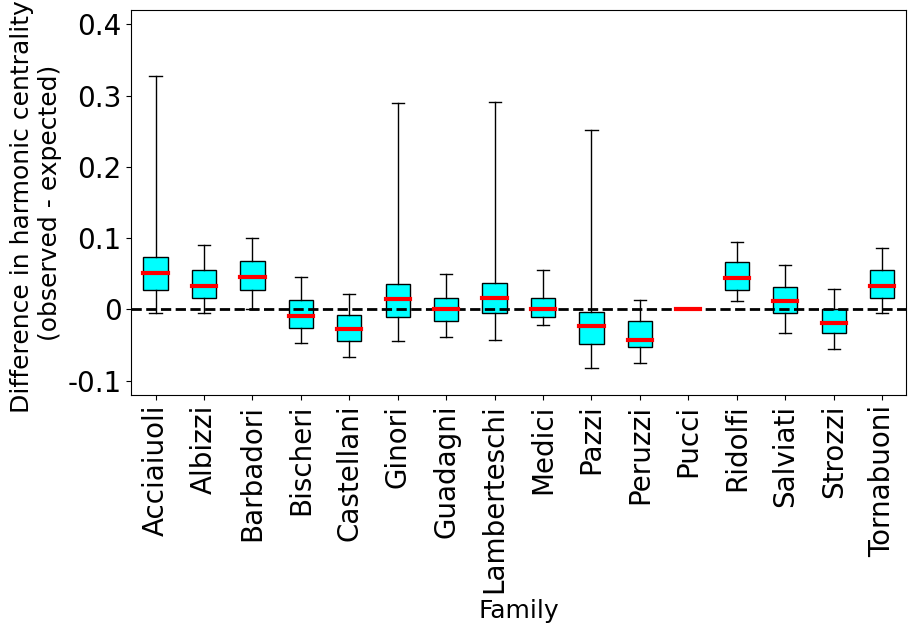

In [9]:
plot_harmonicCentrality_differences(case = "simple")

<Figure size 1000x500 with 0 Axes>

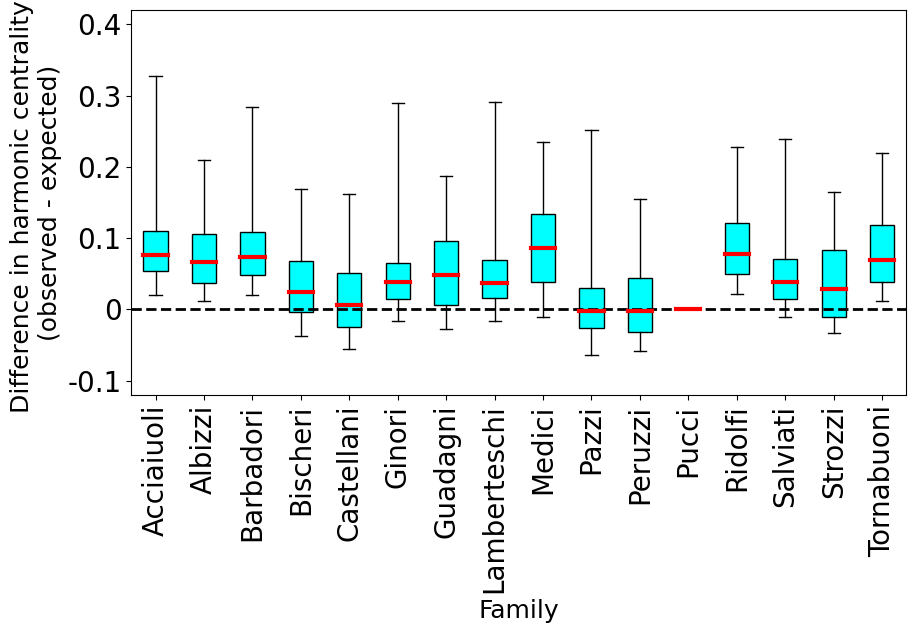

In [10]:
plot_harmonicCentrality_differences(case = "stub-matching")